In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 req

In [2]:
import pandas as pd
from datasets import load_dataset

# Load the dataset splits
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

# Convert the splits to pandas DataFrame
df_train = dataset['train'].to_pandas()
df_validation = dataset['validation'].to_pandas()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [3]:
df_train

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


In [4]:
df_validation

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0
...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2
2384,Stocks making the biggest moves premarket: Fit...,2
2385,Stocks making the biggest moves premarket: Hom...,2
2386,Stocks making the biggest moves premarket: TD ...,2


0 = Bearish

1 = Bullish

2 = Neutral

In [5]:
df_train.dtypes

,0
text,object
label,int64


In [6]:
# Text classification
# Look at number of samples, value_counts
# preprocess pipeline
# training setup
# evaluate

In [7]:
df_train['label'].value_counts()

,count
label,
2,6178
1,1923
0,1442


In [8]:
df_validation['label'].value_counts()

,count
label,
2,1566
1,475
0,347


Look at some random data

In [9]:
import numpy as np

for _ in range(20):
    rand_ind = np.random.randint(0, len(df_train))
    random_data = df_train.iloc[rand_ind]
    print(random_data['text'], random_data['label'])

Sajid Javid to push for 'permanent equivalence' for City in Brexit talks https://t.co/ZYkqhJ6rPS 2
Ruth Bader Ginsburg released from hospital, ‘doing well’ https://t.co/0w5j6BCUue 2
Fed's corporate credit measures to limit buybacks, dividend https://t.co/4FrdSvMV8T 0
$COMDX: Energy Settlement Prices https://t.co/DJdjBeoW0k 2
Barron’s on MarketWatch: Gold has taken a beating — here’s how to play a rebound 2
Hedge Funds Are Dumping Altair Engineering Inc. (ALTR) 0
Chubb to purchase additional 15.3% stake in Huatai Insurance 2
$CTRC $KODK $TEN - Eastman Kodak among consumer gainers; China Automotive Systems only loser https://t.co/MZg3YLMrpU 2
India Online Test Preparation Markets, 2020-2024: Anticipated to Witness a Massive Growth of 39% CAGR -… https://t.co/c6dbdTOIBi 1
Volatility made its appearance today as the Dow gave up a 1000-point rally. The volatility sword cuts both ways. 0
China Travel Bans Leave Thousands Stranded Around the World 2
$FIZZ - National Beverage +4% as analysts k

#### Preprocessing

In [10]:
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()

In [11]:
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# List of lists for input
model_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
labels = torch.tensor(df_train['label'].values)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
model_inputs

{'input_ids': tensor([[  101,   109,   139,  ...,     0,     0,     0],
        [  101,   109, 21362,  ...,     0,     0,     0],
        [  101,   109,   140,  ...,     0,     0,     0],
        ...,
        [  101,   191,  1942,  ...,     0,     0,     0],
        [  101,   160,  9565,  ...,     0,     0,     0],
        [  101,   162, 16769,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [13]:
# Create TensorDataset
tensor_dataset = TensorDataset(model_inputs['input_ids'], model_inputs['attention_mask'], labels)

# Create DataLoader
dataloader = DataLoader(
    tensor_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Build Model

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
from torch import nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)  # Adjust num_labels based on your task
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Set up optimizer

from torch.optim import AdamW

# Set up the optimizer (consider the warning and use torch's AdamW)
optimizer = AdamW(model.parameters(), lr=2e-5)

In [17]:
# Training loop
from tqdm import tqdm  # For progress bars

# Number of epochs for training
num_epochs = 3

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}"):
        # Unpack the batch and move to GPU if available
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training complete!")


Training Epoch 1:   0%|          | 0/597 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training Epoch 1: 100%|██████████| 597/597 [02:58<00:00,  3.34it/s]


Epoch 1/3, Average Loss: 0.5455


Training Epoch 2: 100%|██████████| 597/597 [02:57<00:00,  3.36it/s]


Epoch 2/3, Average Loss: 0.2859


Training Epoch 3: 100%|██████████| 597/597 [02:57<00:00,  3.36it/s]

Epoch 3/3, Average Loss: 0.1492
Training complete!


In [18]:
validation_dataset = dataset['validation']

# Tokenize the validation data
validation_texts = validation_dataset['text']
validation_inputs = tokenizer(validation_texts, padding=True, truncation=True, return_tensors='pt')

# Convert labels to tensors
validation_labels = torch.tensor(validation_dataset['label'])

# Create a TensorDataset and DataLoader for validation data
validation_tensor_dataset = TensorDataset(validation_inputs['input_ids'], validation_inputs['attention_mask'], validation_labels)
validation_dataloader = DataLoader(
    validation_tensor_dataset,
    batch_size=16,
    shuffle=False,  # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)


In [19]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
correct_predictions = 0
total_predictions = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Calculate the number of correct predictions
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 88.19%


In [21]:
from sklearn.metrics import classification_report

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_predictions))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

           0       0.82      0.76      0.79       347
           1       0.82      0.83      0.82       475
           2       0.91      0.93      0.92      1566

    accuracy                           0.88      2388
   macro avg       0.85      0.84      0.84      2388
weighted avg       0.88      0.88      0.88      2388



#### Results

An 87% accuracy on the validation set suggests that the model generalizes reasonably well. Class 2 performs the best with the highest scores, which is expected because of the relatively high number of instances. Class 0 and 1 also show decent performance, with balanced precision and recall scores, with slight trade-offs between the two for each class. Let's explore further to improve upon our understanding.

In [22]:
# analyze misclassifications
# Initialize lists to store misclassified instances
misclassified_texts = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch_idx, batch in enumerate(validation_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Identify misclassified instances
        misclassified_mask = predictions != labels
        misclassified_indices = misclassified_mask.nonzero(as_tuple=True)[0].tolist()

        # Store misclassified instances
        if isinstance(misclassified_indices, list):
            for i in misclassified_indices:
                misclassified_texts.append(validation_texts[batch_idx * validation_dataloader.batch_size + i])
                misclassified_true_labels.append(labels[i].cpu().item())
                misclassified_pred_labels.append(predictions[i].cpu().item())
        elif isinstance(misclassified_indices, int):  # If there's only one misclassified instance
            i = misclassified_indices
            misclassified_texts.append(validation_texts[batch_idx * validation_dataloader.batch_size + i])
            misclassified_true_labels.append(labels[i].cpu().item())
            misclassified_pred_labels.append(predictions[i].cpu().item())

# Create a DataFrame to analyze misclassifications
misclassified_df = pd.DataFrame({
    'Text': misclassified_texts,
    'True Label': misclassified_true_labels,
    'Predicted Label': misclassified_pred_labels
})

# Filter for classes 0 and 1
misclassified_df_01 = misclassified_df[misclassified_df['True Label'].isin([0, 1])]

# Display the misclassified DataFrame
print(misclassified_df_01.head(10))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


                                                 Text  True Label  \
0   Analysts Eviscerate Musk's Cybertruck: "0% Of ...           0   
1   Barclays assigns only a 20% chance that studie...           0   
2   BTIG points to breakfast pressure for Dunkin' ...           0   
3   $OIH $BKR $NOV - Buy oil service firms, Bernst...           1   
4   $URBN - Urban Outfitters stands out in mall se...           1   
5   AM Best Revises Outlooks to Positive for Pacíf...           1   
6   Highlight: Edward Jones Sr. Equity Analyst Jen...           1   
7                Peloton bulls defend the upside case           1   
11  Jerome Powell comes close to acknowledging tha...           0   
12  No, The Fed Won't "Save The Market" - Here's W...           0   

    Predicted Label  
0                 1  
1                 2  
2                 2  
3                 2  
4                 2  
5                 2  
6                 2  
7                 2  
11                2  
12                2 

In [23]:
misclassified_df_01.nunique()

,0
Text,167
True Label,2
Predicted Label,3


In [24]:
for i in range(len(misclassified_df_01)):
  print('Tweet: ', misclassified_df_01['Text'].iloc[i])
  print('True: ', misclassified_df_01['True Label'].iloc[i])
  print('Predicted: ', misclassified_df_01['Predicted Label'].iloc[i])
  print('\n\n')

Tweet:  Analysts Eviscerate Musk's Cybertruck: "0% Of Responses Felt It Will Be A Success" https://t.co/2NTzeZea4G
True:  0
Predicted:  1



Tweet:  Barclays assigns only a 20% chance that studies on a Gilead antiviral drug being done in China will succeed against… https://t.co/lIgDhy1Gli
True:  0
Predicted:  2



Tweet:  BTIG points to breakfast pressure for Dunkin' Brands
True:  0
Predicted:  2



Tweet:  $OIH $BKR $NOV - Buy oil service firms, Bernstein says after seven-year bearish view https://t.co/FFUM7WlJIZ
True:  1
Predicted:  2



Tweet:  $URBN - Urban Outfitters stands out in mall sector - BofA https://t.co/pvig3M420p
True:  1
Predicted:  2



Tweet:  AM Best Revises Outlooks to Positive for Pacífico Compañía de Seguros y Reaseguros S.A. https://t.co/BGvmfeHKod https://t.co/gvtIQzMVbf
True:  1
Predicted:  2



Tweet:  Highlight: Edward Jones Sr. Equity Analyst Jennifer Roland on ExxonMobil reducing 2020 Capex by 30%: “Definitely a… https://t.co/dH0xlJujc1
True:  1
Predicted: 

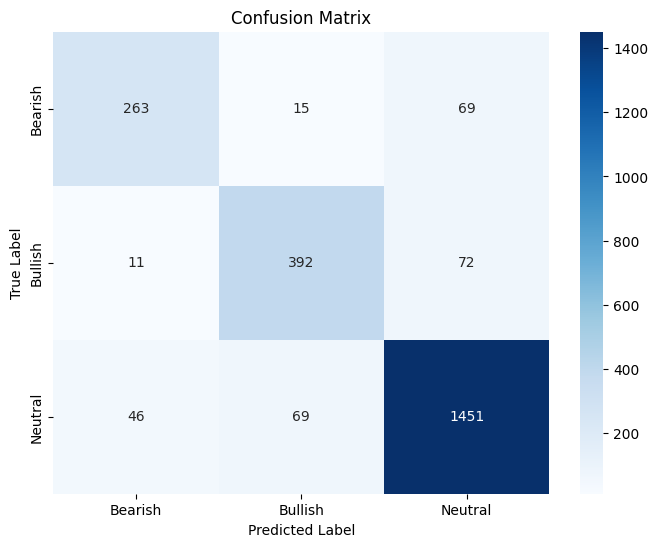

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_predictions and all_labels are already collected as lists
# Convert them to NumPy arrays (if they aren't already)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Define the class labels
class_names = ['Bearish', 'Bullish', 'Neutral']

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



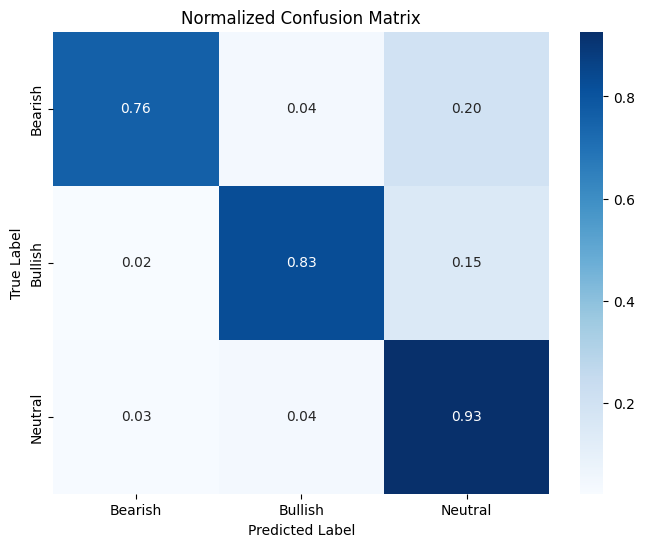

In [26]:
# Normalize
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


Most of the misclassifications come from the model predicting neutral, but the true label is either bullish or bearish. This makes sense as the difference between bullish and bearish is much more distinct, whereas a neural sentiment can be much more ambiguous

Since the model generalizes reasonably well already, lets try implementing RoBERTa, a pre-trained model that is known for its improved performance over BERT on many benchmarks.

In [27]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the pre-trained RoBERTa model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # num_labels=3 for bearish, bullish, neutral
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [28]:
# Tokenize
train_texts = df_train['text'].tolist()
train_labels = torch.tensor(df_train['label'].values)

train_inputs = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')

validation_texts = df_validation['text'].tolist()
validation_labels = torch.tensor(df_validation['label'].values)

validation_inputs = tokenizer(validation_texts, padding=True, truncation=True, return_tensors='pt')

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
validation_dataset = TensorDataset(validation_inputs['input_ids'], validation_inputs['attention_mask'], validation_labels)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Increase the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")


Epoch 1/5, Loss: 0.4358
Epoch 2/5, Loss: 0.2525
Epoch 3/5, Loss: 0.1842
Epoch 4/5, Loss: 0.1240
Epoch 5/5, Loss: 0.0908
Training complete!


Evaluate on validation set

In [30]:
model.eval()  # Set the model to evaluation mode

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_predictions, target_names=['Bearish', 'Bullish', 'Neutral']))


              precision    recall  f1-score   support

     Bearish       0.76      0.89      0.82       347
     Bullish       0.79      0.93      0.85       475
     Neutral       0.97      0.88      0.92      1566

    accuracy                           0.89      2388
   macro avg       0.84      0.90      0.86      2388
weighted avg       0.90      0.89      0.89      2388



A marginal improvement over the original BERT model in terms of accuracy and F1 scores. Particluarly, the recall for the bearish and buullish classes saw significant enhancements, leading to better overall performance.

RoBERTa is slightly better at distinguishing between the different sentiment classes, especially in more challenging cases, like the bearish class.

Overall, RoBERTa seems to be the more optimal model choice and the one we will iterate upon.

In [31]:
from transformers import RobertaModel
import torch.nn as nn

class EnhancedRobertaModel(nn.Module):
    def __init__(self, num_labels=3):
        super(EnhancedRobertaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 64)   # Second fully connected layer
        self.fc3 = nn.Linear(64, num_labels)  # Output layer

    def forward(self, input_ids, attention_mask):
        # Pass through RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Take [CLS] token output

        # Pass through additional layers
        x = self.dropout(cls_output)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)

        return logits

# Initialize the enhanced model
model = EnhancedRobertaModel(num_labels=3)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Use the same tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Training and validation data tokenization would remain the same as before

# Move model to the GPU if available
model.to(device)

# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop (similar to previous)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Validation (similar to previous)
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=['Bearish', 'Bullish', 'Neutral']))

Epoch 1/5, Loss: 0.5957
Epoch 2/5, Loss: 0.3452
Epoch 3/5, Loss: 0.2506
Epoch 4/5, Loss: 0.1880
Epoch 5/5, Loss: 0.1442
              precision    recall  f1-score   support

     Bearish       0.71      0.91      0.80       347
     Bullish       0.86      0.80      0.83       475
     Neutral       0.94      0.90      0.92      1566

    accuracy                           0.89      2388
   macro avg       0.84      0.87      0.85      2388
weighted avg       0.89      0.89      0.89      2388



The overall performance is stable, with the accuracy and weighted averages staying consistent. This indicates that the mode's added complexity did not degrade performance, but also did not significantly enhance it.

The slight decrease in F1-scores for the bearish and bullish classes suggests that the model requires further fine-tuning to fully benefit from the additional layers. The increased complexity might have caused the model to overfit or struggle with more challenging distinctions between bearish and bullish assessments.

The neutral class continues to perform well, as expected for the the majority class.

In [33]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps
total_steps = len(train_dataloader) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)


In [34]:
class EnhancedRobertaModel(nn.Module):
    def __init__(self, num_labels=3, dropout_rate=0.4):
        super(EnhancedRobertaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        x = self.dropout(cls_output)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)

        return logits

# Initialize the model
model = EnhancedRobertaModel(num_labels=3, dropout_rate=0.4)  # Experiment with different dropout rates

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)  # Experiment with learning rates

# Scheduler setup
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate based on scheduler

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluate the model
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=['Bearish', 'Bullish', 'Neutral']))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.7050
Epoch 2/5, Loss: 0.4506
Epoch 3/5, Loss: 0.3013
Epoch 4/5, Loss: 0.2093
Epoch 5/5, Loss: 0.1580
              precision    recall  f1-score   support

     Bearish       0.77      0.88      0.82       347
     Bullish       0.83      0.85      0.84       475
     Neutral       0.94      0.91      0.92      1566

    accuracy                           0.89      2388
   macro avg       0.85      0.88      0.86      2388
weighted avg       0.90      0.89      0.89      2388



Slight Performance Improvement: The fine-tuning steps have resulted in modest improvements in precision, recall, and F1-scores, particularly for the bearish and bullish classes.

Stable Neutral Performance: The neutral class remains the most robust in terms of classification, with high precision and recall.

Model Convergence: The decreasing loss over epochs suggests that the model is converging well, and the learning rate scheduler might have helped in achieving this smoother convergence.
